In [1]:
import tf_keras as keras
from tf_keras import layers
from tf_keras import callbacks # Import for EarlyStopping
import pandas as pd
import tensorflow_probability as tfp
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

tfd = tfp.distributions

In [2]:
# Set a seed value for reproducibility
SEED = 42

# Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(SEED)

# Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

# Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

# Optional: Limit TensorFlow to a single thread (more deterministic)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  

In [3]:
# Load the .ori orientation file
ori_path = "DC3_final_530km_3_month_with_slew_15sbins_EarthLocal.ori"
ori_df = pd.read_csv(
    ori_path,
    delim_whitespace=True,
    skiprows=1,
    header=None,
    names=["prefix", "timestamp", "x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
)
ori_df = ori_df.drop(columns=["prefix"])
ori_df["timestamp"] = pd.to_datetime(ori_df["timestamp"], unit='s')

# Load detector data
time_array = np.load("time_array.npy")
rates = np.squeeze(np.load("total_rates.npy"))
time_series = pd.to_datetime(time_array, unit='s')
rates_df = pd.DataFrame(rates, columns=[f"detector_{i+1}" for i in range(rates.shape[1])])
rates_df["timestamp"] = time_series
rates_df = rates_df[rates_df["timestamp"].dt.hour >= 13]
ori_df = ori_df.dropna(subset=["timestamp"])

# Merge orientation with detector data
merged_df = pd.merge_asof(
    rates_df.sort_values("timestamp"),
    ori_df.sort_values("timestamp"),
    on="timestamp"
).dropna()
merged_df["hour"] = merged_df["timestamp"].dt.hour + merged_df["timestamp"].dt.minute / 60

# remove data with 0 counts and high counts
target_cols = [col for col in merged_df.columns if col.startswith("detector_")]
orientation_features = ["x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
merged_df_no_zeros = merged_df[(merged_df[target_cols] != 0).all(axis=1)]
merged_df_clean = merged_df_no_zeros[(merged_df_no_zeros[target_cols] >= 1000).all(axis=1)]

print("Successfully loaded data from local files.")

C:\Users\mikec\AppData\Local\Temp\ipykernel_17888\35109406.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ori_df = pd.read_csv(


Successfully loaded data from local files.


In [18]:
# Extract features (X) and targets (y)
X = merged_df_clean[orientation_features].values.astype(np.float32)
y = merged_df_clean[target_cols].values.astype(np.float32)

# Split data into training and testing sets
split_index = int(len(X) * 0.8)

# Split the data chronologically
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Standardize the input features
scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("\nData shapes after splitting and scaling:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_test shape: {y_test.shape}")

# Get dimensions from the data
NUM_FEATURES = X_train_scaled.shape[1]
NUM_DETECTORS = y_train.shape[1]


Data shapes after splitting and scaling:
X_train_scaled shape: (1711, 7)
y_train shape: (1711, 6)
X_test_scaled shape: (428, 7)
y_test shape: (428, 6)


In [28]:
def build_nn_positive_normal_model(input_shape, hidden, num_distributions, initial_bias):
    """
    Builds a model that outputs a batch of Normal distributions
    where both loc (mean) and scale (stddev) are constrained to be positive.
    
    Args:
        input_shape (tuple): The shape of the input data).
        hidden (list of int): A list of units for each hidden layer (e.g., [64, 64]).
        num_distributions (int): The number of Normal distributions to model.
        
    Returns:
        A tf.keras.Model instance.
    """
    # Each Normal distribution needs 2 parameters: loc and scale.
    num_params = 2 * num_distributions
    
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    
    # Hidden layers
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)

    params = layers.Dense(
        num_params, 
        activation='linear',
        kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.Constant(initial_bias)
    )(x)
    
    # We define a function to transform the raw network output into our desired distributions.
    dist_func = lambda t: tfd.Independent(
        tfd.Normal(
            # First half of params for `loc`, forced to be positive using exp().
            loc=1e-6 + tf.math.exp(t[..., :num_distributions]),
            
            # Second half for `scale`, also forced to be positive using exp().
            scale=1e-6 + tf.math.exp(t[..., num_distributions:])
        ), 
        reinterpreted_batch_ndims=1 # This ensures the log_prob is a single value per sample.
    )
    
    # The DistributionLambda layer applies our function to the network's output.
    model_out = tfp.layers.DistributionLambda(dist_func)(params)
    
    model = keras.Model(model_in, model_out)
    return model

In [30]:
initial_loc_bias = np.log(np.mean(y_train, axis=0)) 
initial_scale_bias = np.zeros(NUM_DETECTORS)

# Concatenate them into a single bias vector for the final layer
initial_bias = np.concatenate([initial_loc_bias, initial_scale_bias], axis=0)

model = build_nn_positive_normal_model(input_shape=NUM_FEATURES, hidden=[64, 64], num_distributions=NUM_DETECTORS, initial_bias=initial_bias)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_11 (Dense)            (None, 64)                512       
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 12)                780       
                                                                 
 distribution_lambda_4 (Dis  ((None, 6),               0         
 tributionLambda)             (None, 6))                         
                                                                 
Total params: 5452 (21.30 KB)
Trainable params: 5452 (21.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [31]:
# We use the negative log-likelihood, which trains the model to maximize the probability of the observed data.
def negative_log_likelihood(y_true, y_pred_dist):
    return -y_pred_dist.log_prob(y_true)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), 
              loss=negative_log_likelihood)

# Using the imported `callbacks` to add EarlyStopping for robust training
early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Stop if val_loss doesn't improve for 10 epochs
    restore_best_weights=True # Restore the best model weights found
)

In [32]:
print("\n--- Training Model ---")
model.fit(X_train_scaled, y_train, epochs=200, batch_size=64, verbose=1,
          validation_split=0.2, callbacks=[early_stopping_cb])


--- Training Model ---
Epoch 1/200
22/22 [==============================] - 1s 18ms/step - loss: 2757.5740 - val_loss: 1382.6053
Epoch 2/200
22/22 [==============================] - 0s 5ms/step - loss: 312.2135 - val_loss: 571.9447
Epoch 3/200
22/22 [==============================] - 0s 5ms/step - loss: 145.7117 - val_loss: 312.4626
Epoch 4/200
22/22 [==============================] - 0s 5ms/step - loss: 94.6748 - val_loss: 171.9469
Epoch 5/200
22/22 [==============================] - 0s 7ms/step - loss: 66.2390 - val_loss: 132.2523
Epoch 6/200
22/22 [==============================] - 0s 4ms/step - loss: 50.0020 - val_loss: 92.9783
Epoch 7/200
22/22 [==============================] - 0s 4ms/step - loss: 38.8610 - val_loss: 60.8015
Epoch 8/200
22/22 [==============================] - 0s 4ms/step - loss: 33.4485 - val_loss: 47.5380
Epoch 9/200
22/22 [==============================] - 0s 5ms/step - loss: 30.9595 - val_loss: 44.3768
Epoch 10/200
22/22 [==============================] - 0s

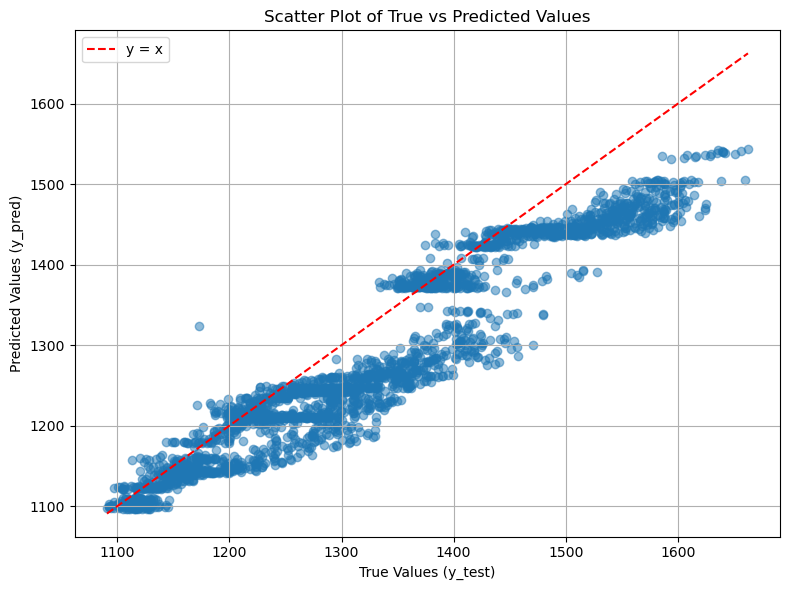

In [33]:
y_pred = model(X_test_scaled).mean().numpy().ravel()
plt.figure(figsize=(8, 6))
plt.scatter(y_test.ravel(), y_pred, alpha=0.5)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of True vs Predicted Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
mean_pred = model(X_test_scaled).mean().numpy()
mse = mean_squared_error(y_test, mean_pred)
print(f"\nMean Squared Error on original scale data: {mse:.2f}")


Mean Squared Error on original scale data: 3641.03
